In [2]:
!pip install pymorphy2
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2075946b68a4979ddbb27020a5bc8f2bdba2d32479f96f503f47c940b8073546
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.6 MB/s eta 0:00:00


In [3]:
from bs4 import BeautifulSoup
import requests as req
import pandas as pd
import numpy as np
import emoji
import re
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, LSTM, Dense, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
import pymorphy2
import seaborn as sns

In [6]:
s2 = BeautifulSoup("", 'html.parser')
s1 = BeautifulSoup("", 'html.parser')


soup1 = BeautifulSoup(open('auto1.html', 'rb').read(), 'html.parser')
soup2 = BeautifulSoup(open('auto2.html', 'rb').read(), 'html.parser')
soup3 = BeautifulSoup(open('auto3.html', 'rb').read(), 'html.parser')
soup4 = BeautifulSoup(open('railway1.html', 'rb').read(), 'html.parser')
soup5 = BeautifulSoup(open('railway2.html', 'rb').read(), 'html.parser')
soup6 = BeautifulSoup(open('railway3.html', 'rb').read(), 'html.parser')


s1.append(soup1)
s1.append(soup2)
s1.append(soup3)


s2.append(soup4)
s2.append(soup5)
s2.append(soup6)

In [7]:
# Ищем только те посты где написан текст, заменя тэги на пробел, чтобы не было слияний
text1 = [i.get_text(" ", strip=True) for i in s1.find_all('div', class_='text')]
text2 = [i.get_text(" ", strip=True) for i in s2.find_all('div', class_='text')]


In [8]:
#функция для привидения текста к нормальному виду
def text_normalize(txt):
  txt = str(txt)
  formats = [r'[\xa0\u200e\u200b]', r'@\S+|#\w+', r'\b[\w\.-]+@[\w\.-]+\.\w+\b', r'\d+', r'[^\w\s]', r'http\S+|https\S+']
  for format in formats:
    txt = re.sub(format, '', txt)
  emoji.replace_emoji(txt, replace='')
  txt = txt.lower()
  return txt



# Собираем датафрейм
df1 = pd.DataFrame({'text': text1, 'id': 0})# 0 - авто
df2 = pd.DataFrame({'text': text2, 'id': 1})# 1 - ж/д транспорт


df = pd.concat([df1[:1200], df2[:1200]], ignore_index=True)

df

,text,id
0,Авто.ру,0
1,#однойкартинкой Вчера компания Tesla объявила ...,0
2,Leading Ideal One: китайский гибридный кроссов...,0
3,​​ Ford показал первое изображение гибридного ...,0
4,#дайджестнедели Самые интересные новости этой ...,0
...,...,...
2395,Инфраструктуру восточного полигона на перегоне...,1
2396,🥇 Первый рефрижератор с продуктами питания отп...,1
2397,🎅🏻 В день рождения Деда Мороза открываем новый...,1
2398,"🤖 ""До чего дошёл прогресс! "" На железнодорожно...",1


In [9]:
# Применяем функцию для нормализации текста
df['text'] = df['text'].apply(text_normalize)


# Удаление стопслов
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,id
0,автору,0
1,вчера компания tesla объявила планах вложить м...,0
2,leading ideal one китайский гибридный кроссове...,0
3,ford показал первое изображение гибридного куп...,0
4,самые интересные новости недели преемник skoda...,0
...,...,...
2395,инфраструктуру восточного полигона перегоне шк...,1
2396,первый рефрижератор продуктами питания отправи...,1
2397,день рождения деда мороза открываем новый сезо...,1
2398,дошёл прогресс железнодорожном вокзале тюмени ...,1


In [10]:
df = df.drop_duplicates()
df.isnull().sum()

text    0
id      0
dtype: int64

In [11]:
# Токенизируем и лемматизируем текст
morph = pymorphy2.MorphAnalyzer()
df['text'] = df['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))
print(df['text'])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])


maxlen = df['text'].apply(lambda x: len(x.split())).max()
X = pad_sequences(X, maxlen=maxlen)
y = df['id']
print(X)

<ipython-input-11-345c565b525f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))


0                                                   автор
1       вчера компания tesla объявить план вложить мил...
2       leading ideal one китайский гибридный кроссове...
3       ford показать первый изображение гибридный куп...
4       самый интересный новость неделя преемник skoda...
                              ...                        
2394    возможность создание контейнерный терминал про...
2395    инфраструктура восточный полигон перегон шкото...
2396    первый рефрижератор продукт питание отправитьс...
2397    день рождение дед мороз открывать новый сезон ...
2398    дойти прогресс железнодорожный вокзал тюмень р...
Name: text, Length: 2396, dtype: object
[[   0    0    0 ...    0    0  391]
 [   0    0    0 ...  218   21    1]
 [   0    0    0 ...  121   50  448]
 ...
 [   0    0    0 ...    2 2219   69]
 [   0    0    0 ...  308  230   36]
 [   0    0    0 ... 2141  279 4755]]


In [74]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128),
    LSTM(64, recurrent_dropout=0.4, return_sequences=True, dropout=0.3),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(units=2, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.4, callbacks=[early_stopping])#model = Sequential([


Epoch 1/50
18/18 [==============================] - 17s 749ms/step - loss: 1.0680 - accuracy: 0.6292 - val_loss: 1.0048 - val_accuracy: 0.9387
Epoch 2/50
18/18 [==============================] - 13s 749ms/step - loss: 0.8482 - accuracy: 0.8912 - val_loss: 0.5984 - val_accuracy: 0.9674
Epoch 3/50
18/18 [==============================] - 13s 741ms/step - loss: 0.4939 - accuracy: 0.9713 - val_loss: 0.3737 - val_accuracy: 0.9739
Epoch 4/50
18/18 [==============================] - 13s 733ms/step - loss: 0.3329 - accuracy: 0.9791 - val_loss: 0.2937 - val_accuracy: 0.9726
Epoch 5/50
18/18 [==============================] - 13s 735ms/step - loss: 0.2651 - accuracy: 0.9887 - val_loss: 0.3454 - val_accuracy: 0.9674
Epoch 6/50
18/18 [==============================] - 13s 729ms/step - loss: 0.1986 - accuracy: 0.9930 - val_loss: 0.1966 - val_accuracy: 0.9804
Epoch 7/50
18/18 [==============================] - 13s 719ms/step - loss: 0.1660 - accuracy: 0.9939 - val_loss: 0.2397 - val_accuracy: 0.9700

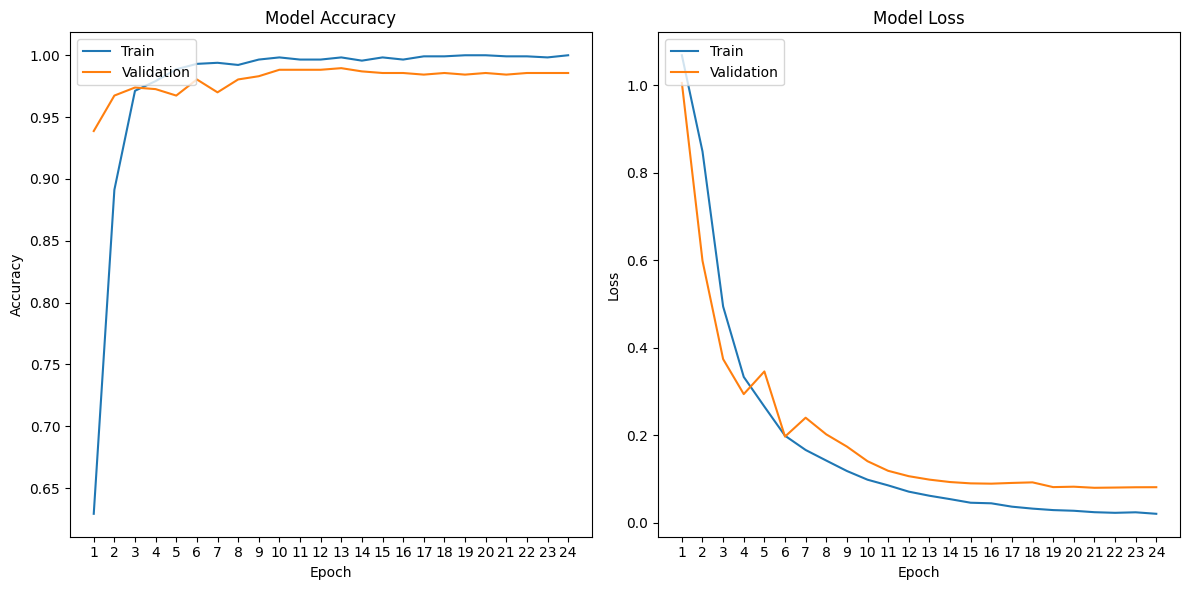

In [75]:
# Generate the epoch range for the x-axis
import matplotlib.pyplot as plt

epochs = np.arange(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(epochs)  # Ensure whole number ticks on x-axis

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.xticks(epochs)  # Ensure whole number ticks on x-axis

plt.tight_layout()
plt.show()

In [76]:
loss_test, acc_test = model.evaluate(X_test, y_test)
loss_train, acc_train = model.evaluate(X_train, y_train)

pred_classes = np.argmax(model.predict(X_test), axis=1)

precision = precision_score(y_test, pred_classes, average='weighted')
recall = recall_score(y_test, pred_classes, average='weighted')
f1 = f1_score(y_test, pred_classes, average='weighted')

print(f'Точность на обучающем наборе: {acc_train}, Точность на тестовом наборе: {acc_test}\nPrecision - test: {precision} \nRecall - test: {recall}\nF1-score - test: {f1}')

15/15 [==============================] - 1s 70ms/step
Точность на обучающем наборе: 0.9937369227409363, Точность на тестовом наборе: 0.9833333492279053
Precision - test: 0.9833333333333333 
Recall - test: 0.9833333333333333
F1-score - test: 0.9833333333333333


15/15 [==============================] - 1s 72ms/step


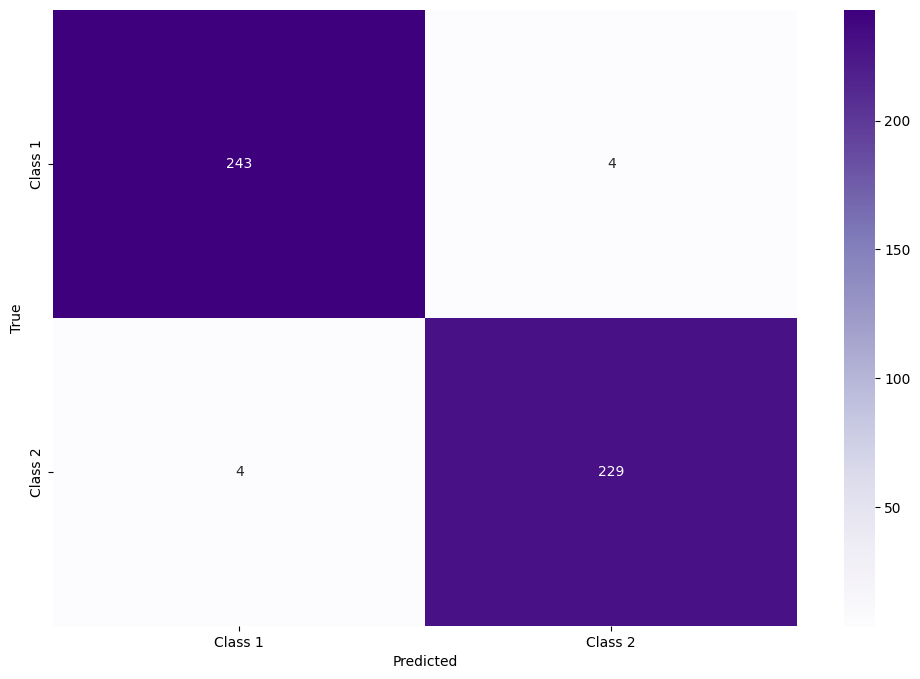

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Визуализация матрицы ошибок с помощью seaborn
class_names = ['Class 1','Class 2']
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Purples", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [79]:
# Предсказание класса для нового текста
import numpy as np

def prepare_text(text):
    text = text_normalize(text)
    text = ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence = pad_sequences(text_sequence, maxlen=maxlen)
    return text_sequence


new_text = "В Москве авто вылетело на встречную полосу. За рулем иномарки BMW был нетрезвый водитель."
prepared_text = prepare_text(new_text)
predict = model.predict(prepared_text)
predict_class = np.argmax(predict)


new_text1 = "Перевозки пассажиров на сети РЖД в мае выросли (https://company.rzd.ru/ru/9397/page/104069?id=299351) на 6,4% Всего в мае поездки совершили более 108 млн пассажиров (+6,4% к маю 2023 года). Из них: 🚆 в пригородном сообщении – 97,6 млн (+6,4%)"
prepared_text1 = prepare_text(new_text1)
predict1 = model.predict(prepared_text1)
predict_class1 = np.argmax(predict1)


def prnt(pred_class):
  if pred_class == 0:
    return '\nКласс - авто'
  else:
    return '\nКласс - ж/д'

print(f'Текст поста - {new_text}{prnt(predict_class)}\nТекст поста - {new_text1}{prnt(predict_class1)}')

1/1 [==============================] - 0s 49ms/step
Текст поста - В Москве авто вылетело на встречную полосу. За рулем иномарки BMW был нетрезвый водитель.
Класс - авто
Текст поста - Перевозки пассажиров на сети РЖД в мае выросли (https://company.rzd.ru/ru/9397/page/104069?id=299351) на 6,4% Всего в мае поездки совершили более 108 млн пассажиров (+6,4% к маю 2023 года). Из них: 🚆 в пригородном сообщении – 97,6 млн (+6,4%)
Класс - ж/д
